In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FFNN_model
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import time
import sys
import os

## Load dataset

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X data type: {X.dtype}")
print(f"y data type: {y.dtype}")

X shape: (70000, 784)
y shape: (70000,)
X data type: int64
y data type: object


convert string labels to int

In [3]:
y = y.astype(np.int64)
y.dtype

dtype('int64')

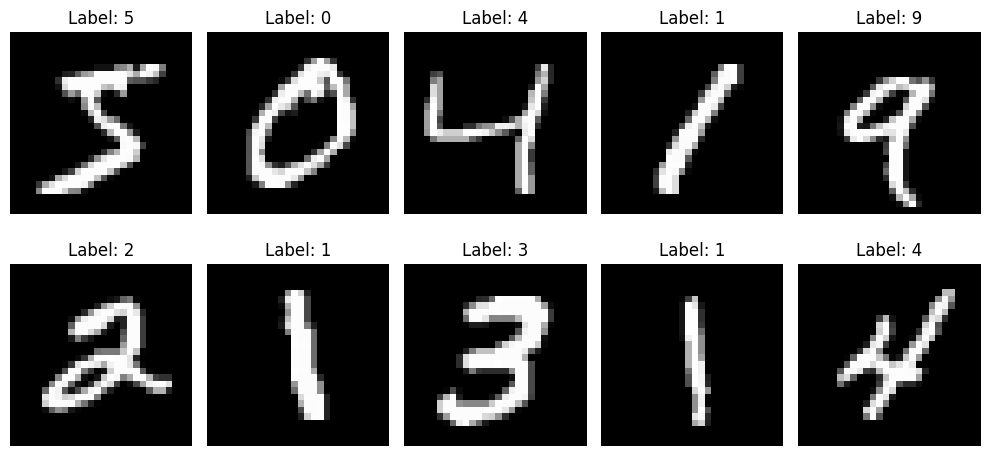

In [4]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Preprocessing Data

In [5]:
X_scaled = X/255.0

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the data
X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42
)

# original labels for evaluation
_, _, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 56000
Test set size: 14000


smaller data train for faster experiment

In [6]:
X_train_small, _, y_train_onehot_small, _ = train_test_split(
    X_train, y_train_onehot, test_size=0.8, random_state=42
)

X_test_small, _, y_test_onehot_small, _ = train_test_split(
    X_test, y_test_onehot, test_size=0.8, random_state=42
)

print(f"Small training set size: {X_train_small.shape[0]}")
print(f"Small test set size: {X_test_small.shape[0]}")

Small training set size: 11200
Small test set size: 2800


## Visualization

In [7]:
def evaluate_model(model, X_test, y_test_onehot, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_onehot, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Plot some examples
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flatten()):
        idx = np.random.randint(0, len(X_test))
        img = X_test[idx].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        true_label = np.argmax(y_test_onehot[idx])
        pred_label = np.argmax(y_pred_probs[idx])
        ax.set_title(f"True: {true_label}, Pred: {pred_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return accuracy, y_pred

In [8]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Experiment 1 : Effect of Depth and Width

In [9]:
# Define the different architectures
architectures = [
    # Varying width (fixed depth)
    {
        'name': 'Small width',
        'layers': [32, 10],
        'activations': ['relu', 'softmax']
    },
    {
        'name': 'Medium width',
        'layers': [64, 10],
        'activations': ['relu', 'softmax']
    },
    {
        'name': 'Large width',
        'layers': [128, 10],
        'activations': ['relu', 'softmax']
    },
    
    # Varying depth (fixed width)
    {
        'name': 'Shallow depth',
        'layers': [64, 10],
        'activations': ['relu', 'softmax']
    },
    {
        'name': 'Medium depth',
        'layers': [64, 32, 10],
        'activations': ['relu', 'relu', 'softmax']
    },
    {
        'name': 'Deep network',
        'layers': [128, 64, 32, 10],
        'activations': ['relu', 'relu', 'relu', 'softmax']
    }
]

params = {
    'epochs': 20,
    'batch_size': 32,
    'learning_rate': 0.01
}


Training model with architecture: Small width
Layers: [32, 10]
Activations: ['relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.0889 - val_loss: 1.8780
Epoch 2/20 [10.0%] - train_loss: 1.7001 - val_loss: 1.5432
Epoch 3/20 [15.0%] - train_loss: 1.4063 - val_loss: 1.2859
Epoch 4/20 [20.0%] - train_loss: 1.1836 - val_loss: 1.0928
Epoch 5/20 [25.0%] - train_loss: 1.0187 - val_loss: 0.9521
Epoch 6/20 [30.0%] - train_loss: 0.9006 - val_loss: 0.8521
Epoch 7/20 [35.0%] - train_loss: 0.8152 - val_loss: 0.7785
Epoch 8/20 [40.0%] - train_loss: 0.7508 - val_loss: 0.7222
Epoch 9/20 [45.0%] - train_loss: 0.7006 - val_loss: 0.6773
Epoch 10/20 [50.0%] - train_loss: 0.6602 - val_loss: 0.6409
Epoch 11/20 [55.0%] - train_loss: 0.6270 - val_loss: 0.6107
Epoch 12/20 [60.0%] - train_loss: 0.5991 - val_loss: 0.5852
Epoch 13/20 [65.0%] - train_loss: 0.5753 - val_loss: 0.5633
Epoch 14/20 [70.0%] - train_loss: 0.5547 - val_loss: 0.5444
Epoch 15/20 [75.0%] - train_loss: 0.5368 - val_loss: 0.5276
Epoch 16/20 [

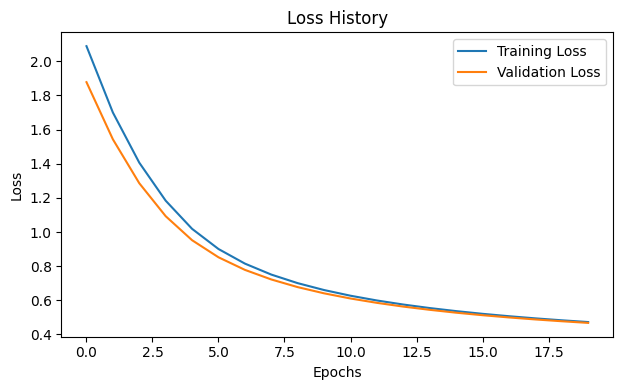


Evaluating model with Small width [32, 10] activation...
Accuracy: 0.8764
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1343
           1       0.90      0.97      0.93      1600
           2       0.88      0.84      0.86      1380
           3       0.85      0.85      0.85      1433
           4       0.87      0.87      0.87      1295
           5       0.85      0.80      0.83      1273
           6       0.89      0.91      0.90      1396
           7       0.90      0.89      0.90      1503
           8       0.84      0.80      0.82      1357
           9       0.83      0.87      0.85      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.87      0.87     14000
weighted avg       0.88      0.88      0.88     14000



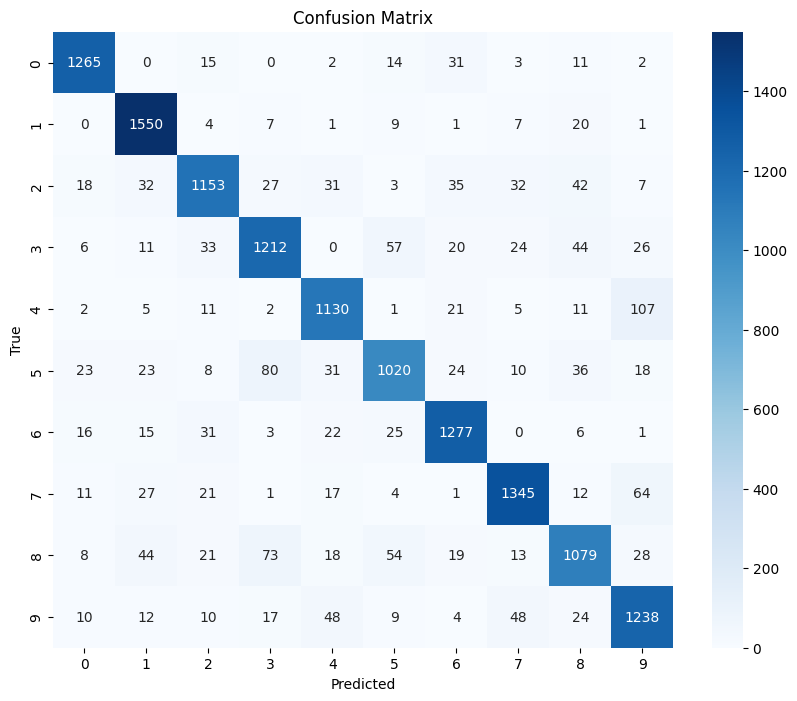

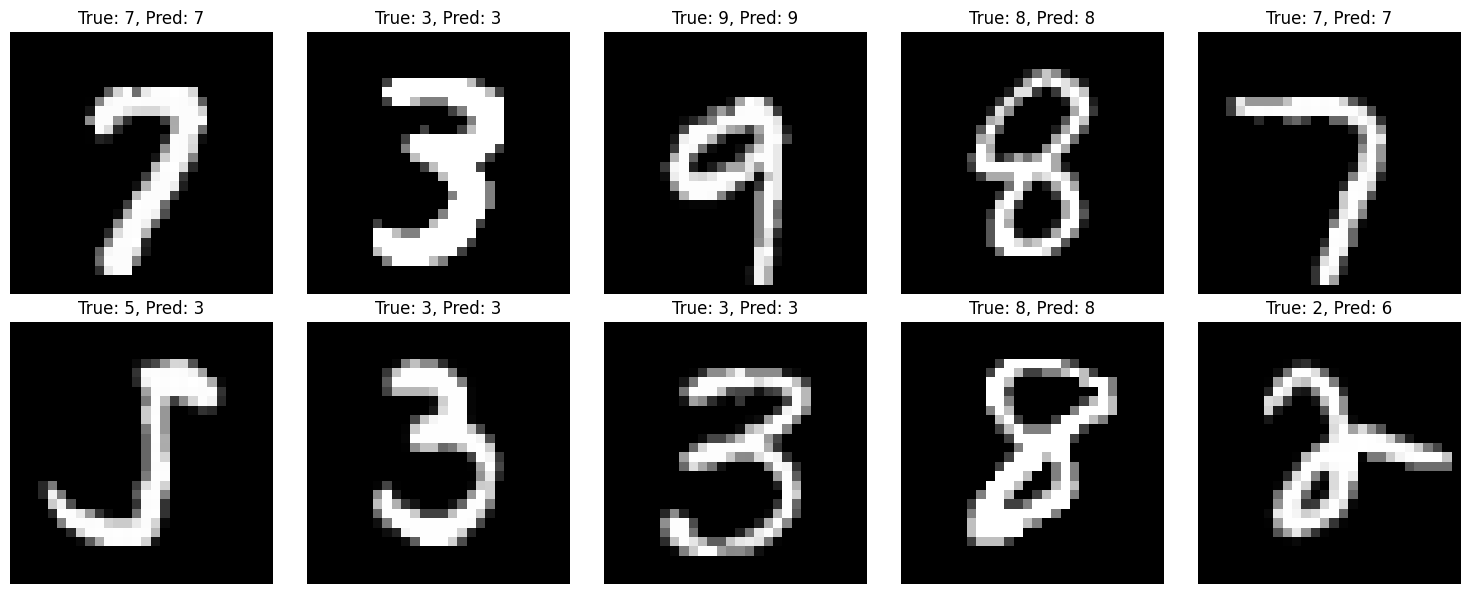


Training model with architecture: Medium width
Layers: [64, 10]
Activations: ['relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.1349 - val_loss: 1.9080
Epoch 2/20 [10.0%] - train_loss: 1.7146 - val_loss: 1.5387
Epoch 3/20 [15.0%] - train_loss: 1.3953 - val_loss: 1.2640
Epoch 4/20 [20.0%] - train_loss: 1.1634 - val_loss: 1.0690
Epoch 5/20 [25.0%] - train_loss: 0.9993 - val_loss: 0.9302
Epoch 6/20 [30.0%] - train_loss: 0.8817 - val_loss: 0.8296
Epoch 7/20 [35.0%] - train_loss: 0.7953 - val_loss: 0.7548
Epoch 8/20 [40.0%] - train_loss: 0.7300 - val_loss: 0.6976
Epoch 9/20 [45.0%] - train_loss: 0.6794 - val_loss: 0.6524
Epoch 10/20 [50.0%] - train_loss: 0.6389 - val_loss: 0.6160
Epoch 11/20 [55.0%] - train_loss: 0.6059 - val_loss: 0.5861
Epoch 12/20 [60.0%] - train_loss: 0.5785 - val_loss: 0.5610
Epoch 13/20 [65.0%] - train_loss: 0.5553 - val_loss: 0.5397
Epoch 14/20 [70.0%] - train_loss: 0.5354 - val_loss: 0.5214
Epoch 15/20 [75.0%] - train_loss: 0.5182 - val_loss: 0.5053
Epoch 16/20 

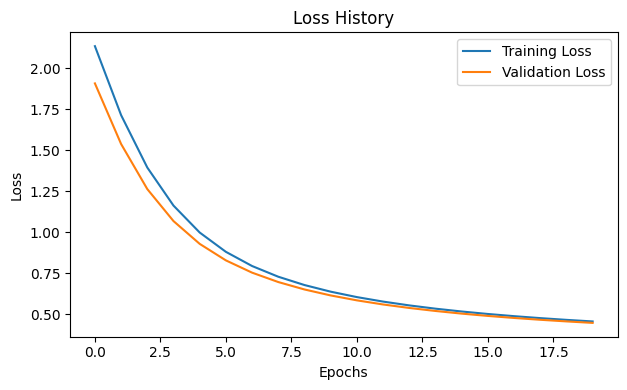


Evaluating model with Medium width [64, 10] activation...
Accuracy: 0.8825
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1343
           1       0.91      0.96      0.93      1600
           2       0.88      0.83      0.86      1380
           3       0.85      0.85      0.85      1433
           4       0.87      0.90      0.88      1295
           5       0.87      0.80      0.83      1273
           6       0.90      0.92      0.91      1396
           7       0.90      0.90      0.90      1503
           8       0.85      0.83      0.84      1357
           9       0.86      0.86      0.86      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



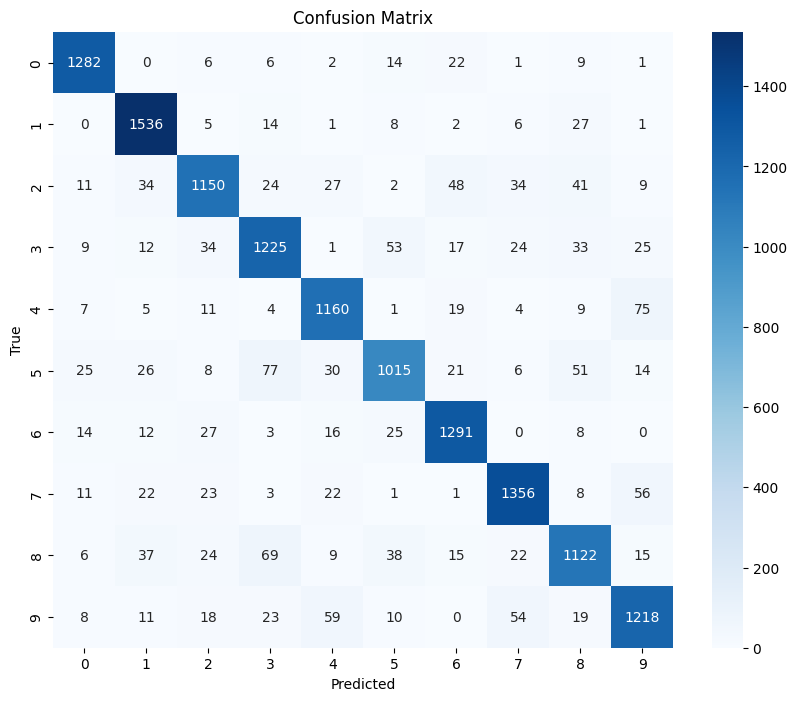

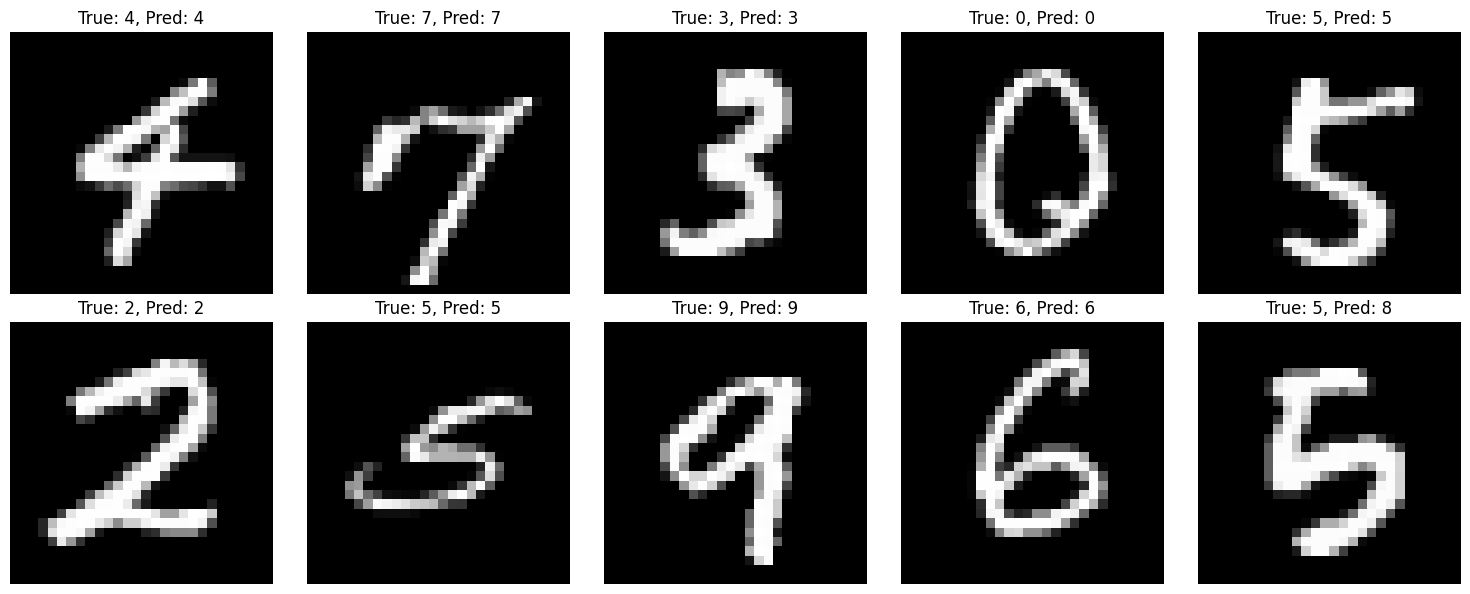


Training model with architecture: Large width
Layers: [128, 10]
Activations: ['relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.0910 - val_loss: 1.8662
Epoch 2/20 [10.0%] - train_loss: 1.6726 - val_loss: 1.4964
Epoch 3/20 [15.0%] - train_loss: 1.3512 - val_loss: 1.2228
Epoch 4/20 [20.0%] - train_loss: 1.1232 - val_loss: 1.0343
Epoch 5/20 [25.0%] - train_loss: 0.9661 - val_loss: 0.9033
Epoch 6/20 [30.0%] - train_loss: 0.8554 - val_loss: 0.8094
Epoch 7/20 [35.0%] - train_loss: 0.7745 - val_loss: 0.7395
Epoch 8/20 [40.0%] - train_loss: 0.7131 - val_loss: 0.6857
Epoch 9/20 [45.0%] - train_loss: 0.6650 - val_loss: 0.6430
Epoch 10/20 [50.0%] - train_loss: 0.6263 - val_loss: 0.6082
Epoch 11/20 [55.0%] - train_loss: 0.5946 - val_loss: 0.5795
Epoch 12/20 [60.0%] - train_loss: 0.5680 - val_loss: 0.5552
Epoch 13/20 [65.0%] - train_loss: 0.5454 - val_loss: 0.5346
Epoch 14/20 [70.0%] - train_loss: 0.5260 - val_loss: 0.5167
Epoch 15/20 [75.0%] - train_loss: 0.5091 - val_loss: 0.5010
Epoch 16/20 

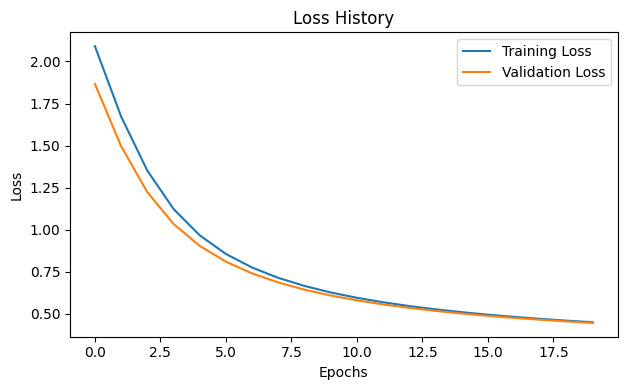


Evaluating model with Large width [128, 10] activation...
Accuracy: 0.8831
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1343
           1       0.91      0.97      0.94      1600
           2       0.87      0.84      0.86      1380
           3       0.86      0.86      0.86      1433
           4       0.87      0.89      0.88      1295
           5       0.87      0.79      0.83      1273
           6       0.90      0.92      0.91      1396
           7       0.90      0.90      0.90      1503
           8       0.84      0.83      0.83      1357
           9       0.85      0.85      0.85      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



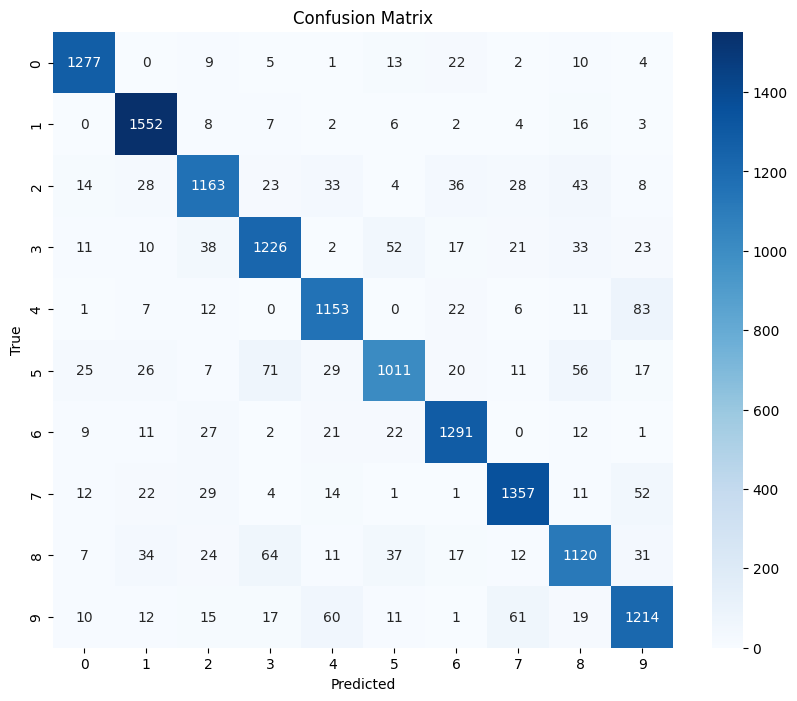

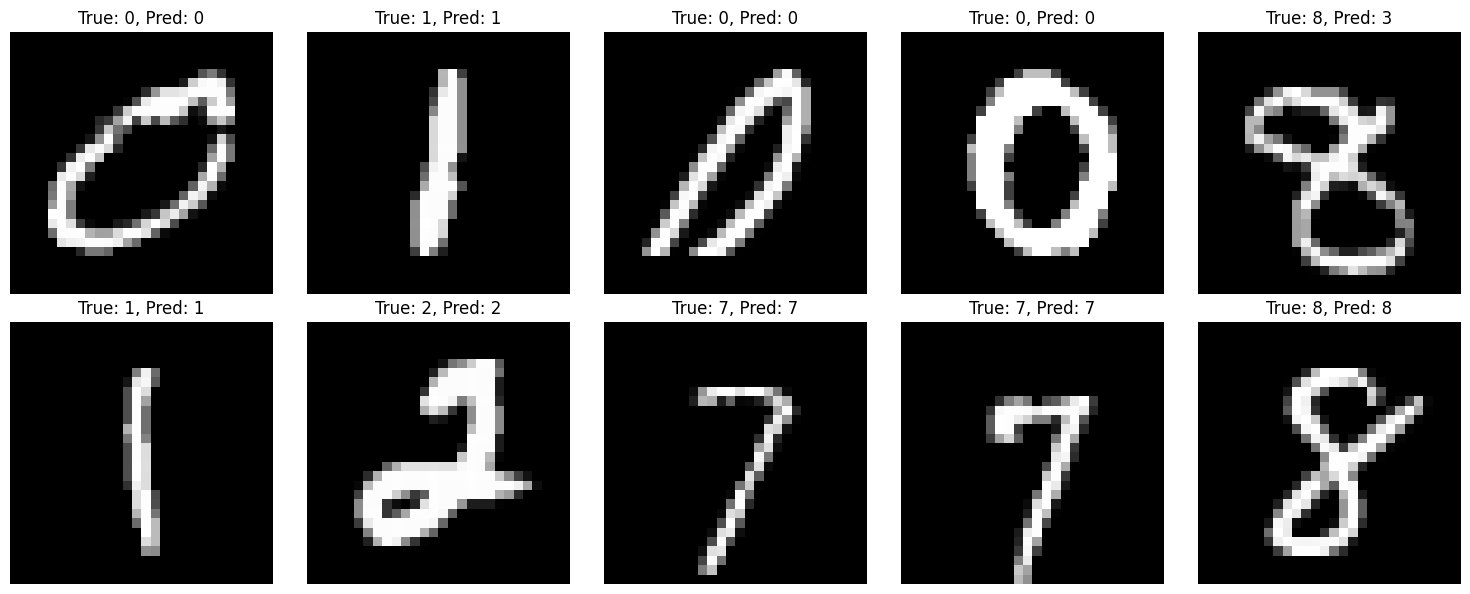


Training model with architecture: Shallow depth
Layers: [64, 10]
Activations: ['relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.1349 - val_loss: 1.9080
Epoch 2/20 [10.0%] - train_loss: 1.7146 - val_loss: 1.5387
Epoch 3/20 [15.0%] - train_loss: 1.3953 - val_loss: 1.2640
Epoch 4/20 [20.0%] - train_loss: 1.1634 - val_loss: 1.0690
Epoch 5/20 [25.0%] - train_loss: 0.9993 - val_loss: 0.9302
Epoch 6/20 [30.0%] - train_loss: 0.8817 - val_loss: 0.8296
Epoch 7/20 [35.0%] - train_loss: 0.7953 - val_loss: 0.7548
Epoch 8/20 [40.0%] - train_loss: 0.7300 - val_loss: 0.6976
Epoch 9/20 [45.0%] - train_loss: 0.6794 - val_loss: 0.6524
Epoch 10/20 [50.0%] - train_loss: 0.6389 - val_loss: 0.6160
Epoch 11/20 [55.0%] - train_loss: 0.6059 - val_loss: 0.5861
Epoch 12/20 [60.0%] - train_loss: 0.5785 - val_loss: 0.5610
Epoch 13/20 [65.0%] - train_loss: 0.5553 - val_loss: 0.5397
Epoch 14/20 [70.0%] - train_loss: 0.5354 - val_loss: 0.5214
Epoch 15/20 [75.0%] - train_loss: 0.5182 - val_loss: 0.5053
Epoch 16/20

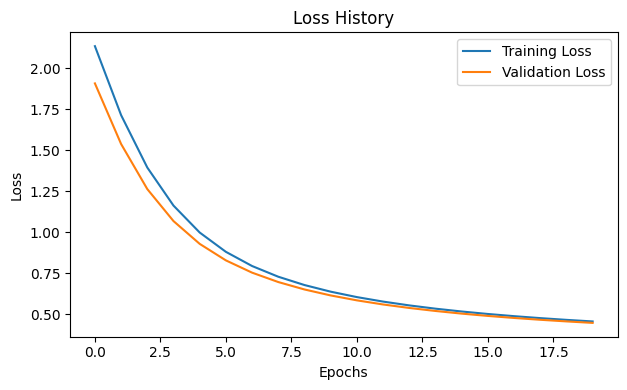


Evaluating model with Shallow depth [64, 10] activation...
Accuracy: 0.8825
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1343
           1       0.91      0.96      0.93      1600
           2       0.88      0.83      0.86      1380
           3       0.85      0.85      0.85      1433
           4       0.87      0.90      0.88      1295
           5       0.87      0.80      0.83      1273
           6       0.90      0.92      0.91      1396
           7       0.90      0.90      0.90      1503
           8       0.85      0.83      0.84      1357
           9       0.86      0.86      0.86      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



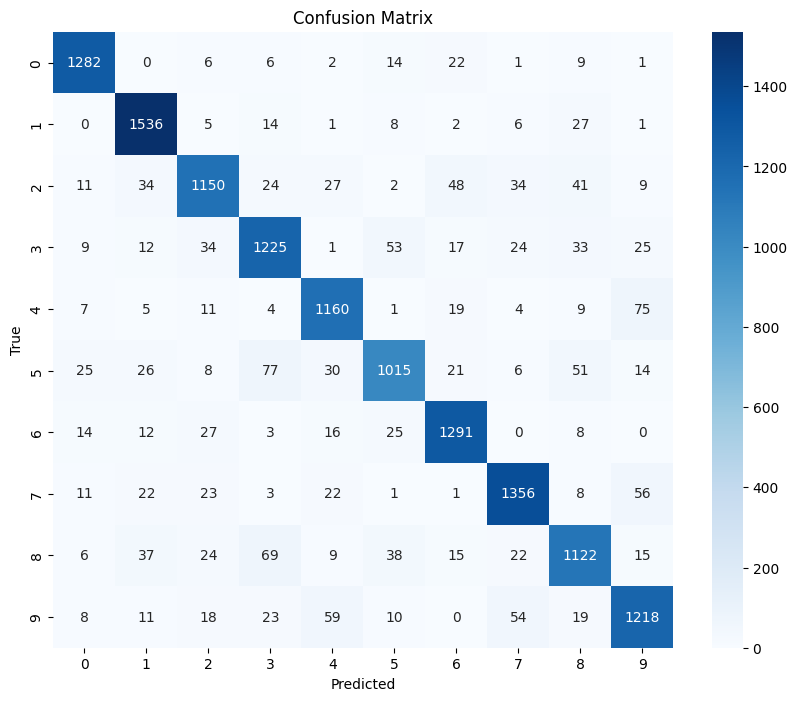

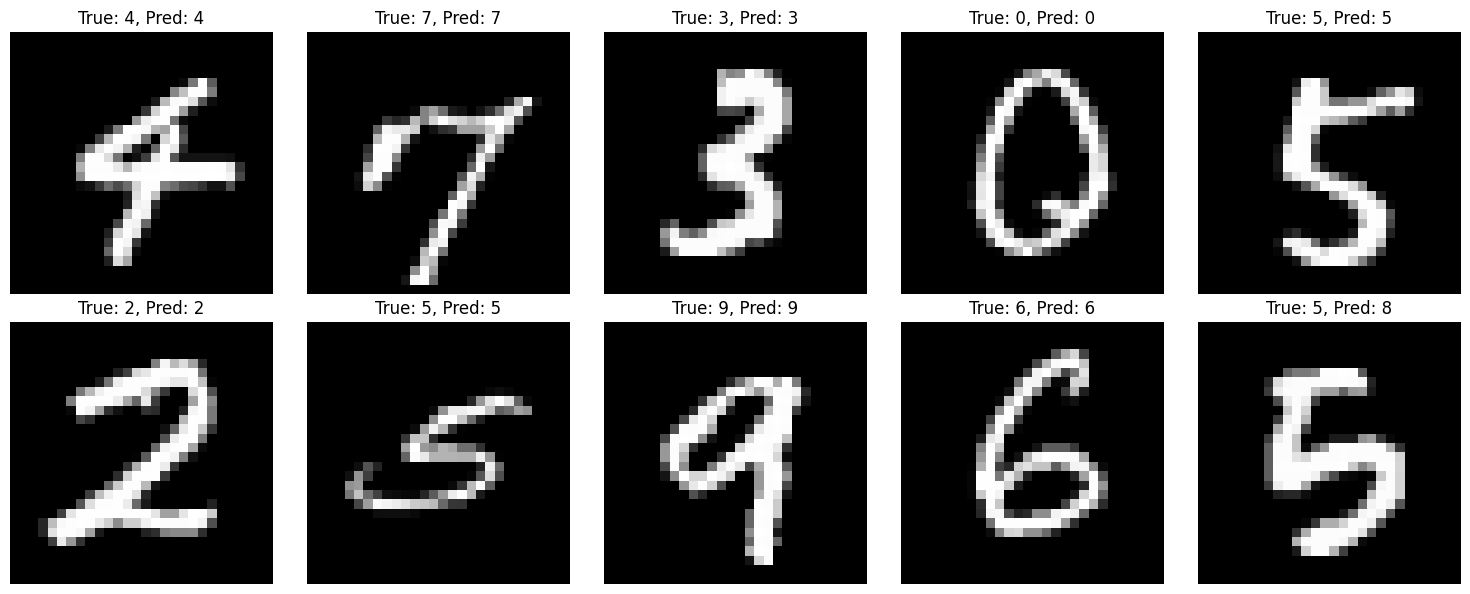


Training model with architecture: Medium depth
Layers: [64, 32, 10]
Activations: ['relu', 'relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.0968 - val_loss: 1.8448
Epoch 2/20 [10.0%] - train_loss: 1.6291 - val_loss: 1.4279
Epoch 3/20 [15.0%] - train_loss: 1.2717 - val_loss: 1.1299
Epoch 4/20 [20.0%] - train_loss: 1.0333 - val_loss: 0.9425
Epoch 5/20 [25.0%] - train_loss: 0.8835 - val_loss: 0.8221
Epoch 6/20 [30.0%] - train_loss: 0.7836 - val_loss: 0.7385
Epoch 7/20 [35.0%] - train_loss: 0.7121 - val_loss: 0.6770
Epoch 8/20 [40.0%] - train_loss: 0.6577 - val_loss: 0.6293
Epoch 9/20 [45.0%] - train_loss: 0.6145 - val_loss: 0.5906
Epoch 10/20 [50.0%] - train_loss: 0.5791 - val_loss: 0.5586
Epoch 11/20 [55.0%] - train_loss: 0.5494 - val_loss: 0.5315
Epoch 12/20 [60.0%] - train_loss: 0.5241 - val_loss: 0.5086
Epoch 13/20 [65.0%] - train_loss: 0.5021 - val_loss: 0.4888
Epoch 14/20 [70.0%] - train_loss: 0.4829 - val_loss: 0.4714
Epoch 15/20 [75.0%] - train_loss: 0.4661 - val_loss: 0.4556


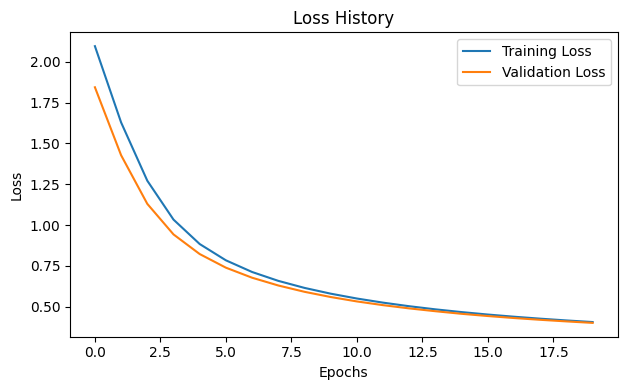


Evaluating model with Medium depth [64, 32, 10] activation...
Accuracy: 0.8910
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1343
           1       0.92      0.97      0.95      1600
           2       0.90      0.85      0.88      1380
           3       0.86      0.86      0.86      1433
           4       0.88      0.91      0.89      1295
           5       0.85      0.82      0.84      1273
           6       0.90      0.94      0.92      1396
           7       0.92      0.91      0.91      1503
           8       0.85      0.81      0.83      1357
           9       0.88      0.87      0.87      1420

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



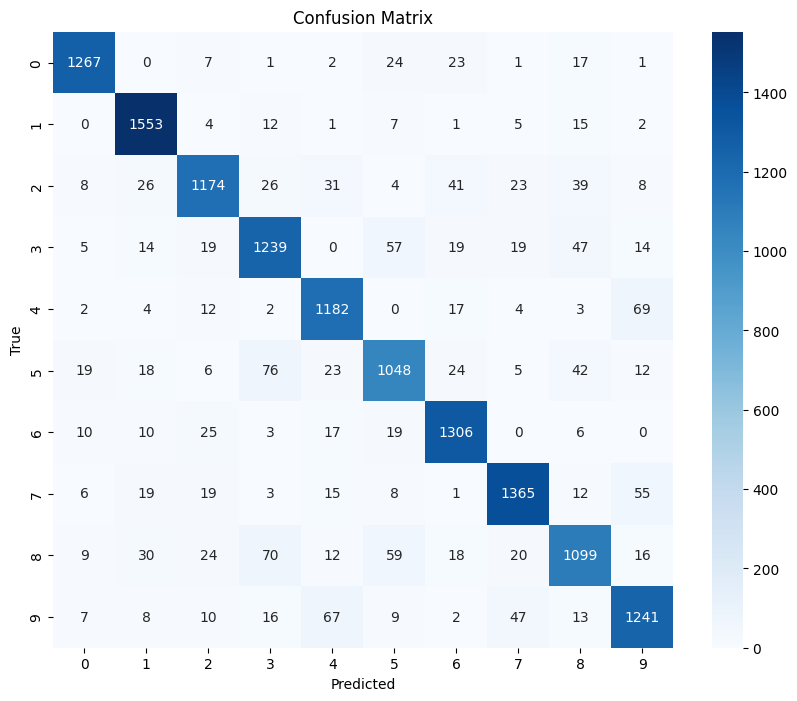

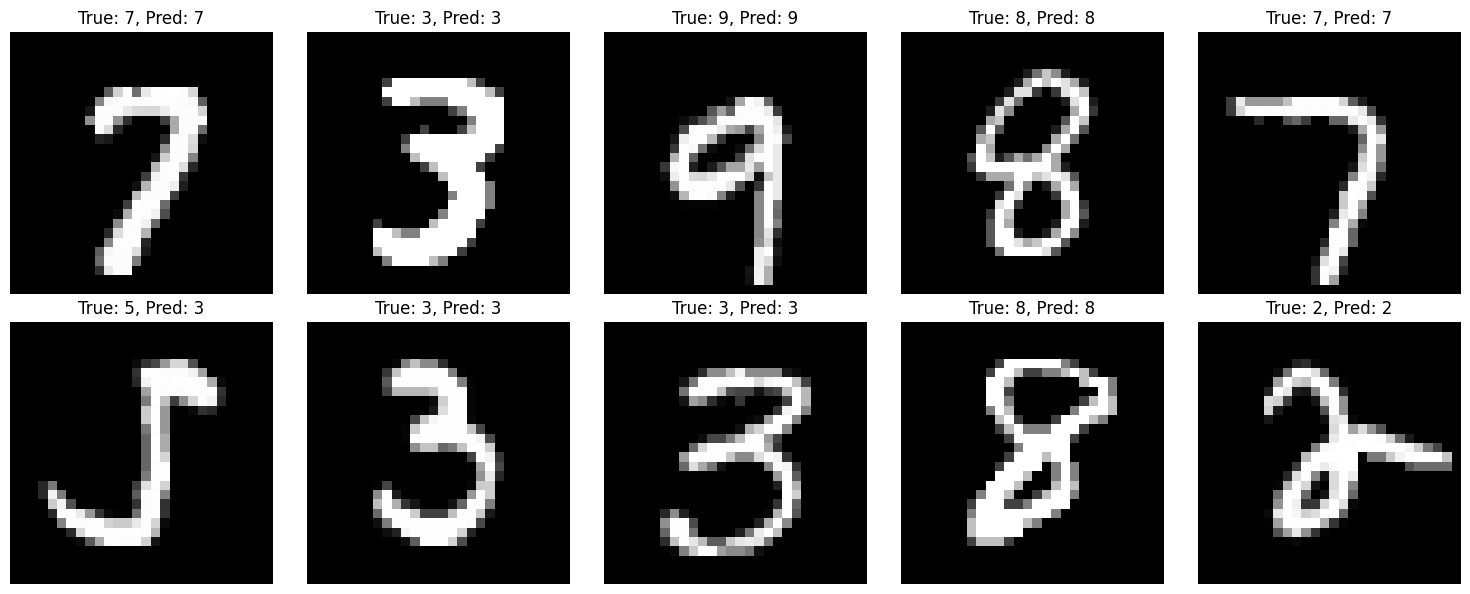


Training model with architecture: Deep network
Layers: [128, 64, 32, 10]
Activations: ['relu', 'relu', 'relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.1465 - val_loss: 1.9462
Epoch 2/20 [10.0%] - train_loss: 1.7202 - val_loss: 1.4943
Epoch 3/20 [15.0%] - train_loss: 1.3058 - val_loss: 1.1358
Epoch 4/20 [20.0%] - train_loss: 1.0134 - val_loss: 0.9048
Epoch 5/20 [25.0%] - train_loss: 0.8279 - val_loss: 0.7559
Epoch 6/20 [30.0%] - train_loss: 0.7044 - val_loss: 0.6539
Epoch 7/20 [35.0%] - train_loss: 0.6185 - val_loss: 0.5828
Epoch 8/20 [40.0%] - train_loss: 0.5574 - val_loss: 0.5316
Epoch 9/20 [45.0%] - train_loss: 0.5123 - val_loss: 0.4928
Epoch 10/20 [50.0%] - train_loss: 0.4778 - val_loss: 0.4631
Epoch 11/20 [55.0%] - train_loss: 0.4507 - val_loss: 0.4396
Epoch 12/20 [60.0%] - train_loss: 0.4288 - val_loss: 0.4205
Epoch 13/20 [65.0%] - train_loss: 0.4107 - val_loss: 0.4048
Epoch 14/20 [70.0%] - train_loss: 0.3956 - val_loss: 0.3916
Epoch 15/20 [75.0%] - train_loss: 0.3827 - val_

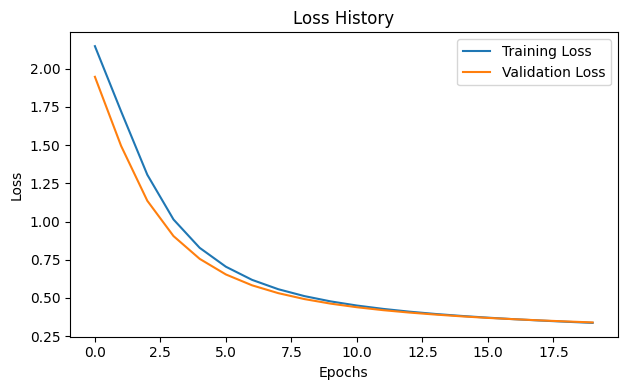


Evaluating model with Deep network [128, 64, 32, 10] activation...
Accuracy: 0.9040
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1343
           1       0.94      0.97      0.95      1600
           2       0.92      0.87      0.90      1380
           3       0.88      0.87      0.87      1433
           4       0.88      0.91      0.90      1295
           5       0.86      0.86      0.86      1273
           6       0.92      0.94      0.93      1396
           7       0.92      0.92      0.92      1503
           8       0.86      0.84      0.85      1357
           9       0.89      0.88      0.88      1420

    accuracy                           0.90     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.90      0.90      0.90     14000



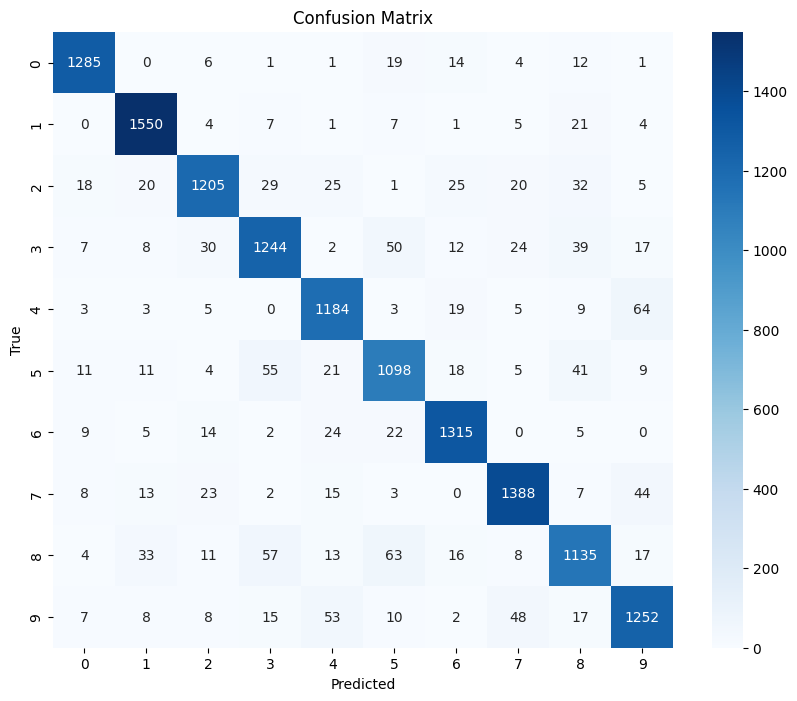

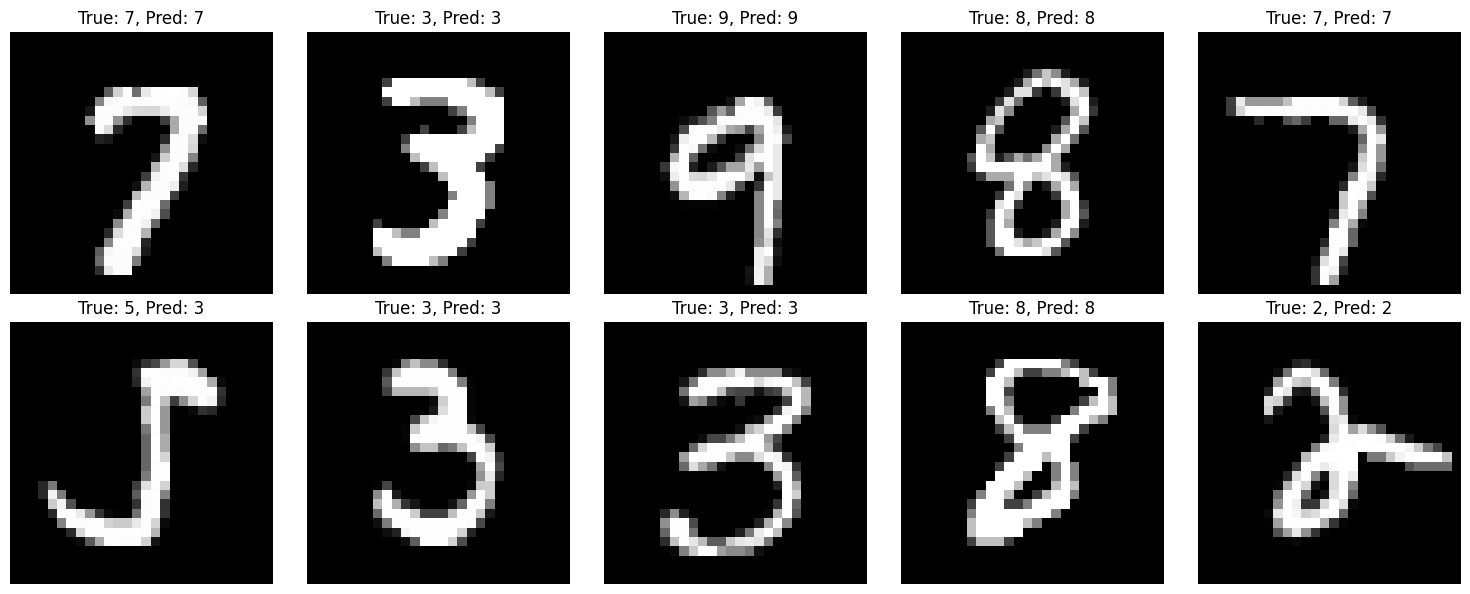


Activation Function Comparison Results:
                             name  accuracy  final_train_loss  final_val_loss  \
0            Small width [32, 10]  0.876357          0.472732        0.467809   
1           Medium width [64, 10]  0.882500          0.457522        0.448745   
2           Large width [128, 10]  0.883143          0.449202        0.445311   
3          Shallow depth [64, 10]  0.882500          0.457522        0.448745   
4       Medium depth [64, 32, 10]  0.891000          0.405075        0.399948   
5  Deep network [128, 64, 32, 10]  0.904000          0.337241        0.340229   

   training_time  
0      25.826034  
1      30.631998  
2      40.894742  
3      31.946117  
4      32.898258  
5      51.223317  

Activation Function Comparison Results:
                             name  accuracy  final_train_loss  final_val_loss  \
0            Small width [32, 10]  0.876357          0.472732        0.467809   
1           Medium width [64, 10]  0.882500          0.

In [11]:
width_results = []
depth_results = []

for i, arch in enumerate(architectures):
    print(f"\nTraining model with architecture: {arch['name']}")
    print(f"Layers: {arch['layers']}")
    print(f"Activations: {arch['activations']}")
    
    # Initialize the model
    model = FFNN_model.FeedforwardNeuralNetwork(
        input_size=X_train.shape[1],
        layer_sizes=arch['layers'],
        activations=arch['activations'],
        loss='categorical_cross_entropy',
        weight_init='he',
        weight_init_params={'seed': 42}
    )
    
    # Train the model
    start_time = time.time()
    history = model.train(
        X_train=X_train,
        y_train=y_train_onehot,
        X_val=X_test,
        y_val=y_test_onehot,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate'],
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Plot training history
    plot_history(history)

    # Evaluate model
    print(f"\nEvaluating model with {arch['name']} {arch['layers']} activation...")
    accuracy, _ = evaluate_model(model, X_test, y_test_onehot, y_test)

     # Store results
    width_results.append({
        'name': f"{arch['name']} {arch['layers']}",
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })
    depth_results.append({
        'name': f"{arch['name']} {arch['layers']}",
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })
    

print("\nActivation Function Comparison Results:")
widht_df = pd.DataFrame(width_results)
print(widht_df[['name', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])

print("\nActivation Function Comparison Results:")
depth_df = pd.DataFrame(width_results)
print(depth_df[['name', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])
    

## Experiment 2 : Effect of Activation Function

In [12]:
activation_functions = ['linear', 'relu', 'sigmoid', 'tanh']

base_architecture = {
    'layers': [64, 32, 10],
    'loss': 'categorical_cross_entropy'
}

params = {
    'epochs': 20,
    'batch_size': 32,
    'learning_rate': 0.01
}


Training model with activation: linear
Epoch 1/20 [5.0%] - train_loss: 1.6579 - val_loss: 1.1611
Epoch 2/20 [10.0%] - train_loss: 0.9717 - val_loss: 0.8304
Epoch 3/20 [15.0%] - train_loss: 0.7547 - val_loss: 0.6876
Epoch 4/20 [20.0%] - train_loss: 0.6473 - val_loss: 0.6074
Epoch 5/20 [25.0%] - train_loss: 0.5824 - val_loss: 0.5556
Epoch 6/20 [30.0%] - train_loss: 0.5384 - val_loss: 0.5192
Epoch 7/20 [35.0%] - train_loss: 0.5064 - val_loss: 0.4920
Epoch 8/20 [40.0%] - train_loss: 0.4819 - val_loss: 0.4709
Epoch 9/20 [45.0%] - train_loss: 0.4625 - val_loss: 0.4536
Epoch 10/20 [50.0%] - train_loss: 0.4466 - val_loss: 0.4396
Epoch 11/20 [55.0%] - train_loss: 0.4334 - val_loss: 0.4278
Epoch 12/20 [60.0%] - train_loss: 0.4222 - val_loss: 0.4178
Epoch 13/20 [65.0%] - train_loss: 0.4126 - val_loss: 0.4093
Epoch 14/20 [70.0%] - train_loss: 0.4042 - val_loss: 0.4017
Epoch 15/20 [75.0%] - train_loss: 0.3968 - val_loss: 0.3949
Epoch 16/20 [80.0%] - train_loss: 0.3902 - val_loss: 0.3890
Epoch 17/2

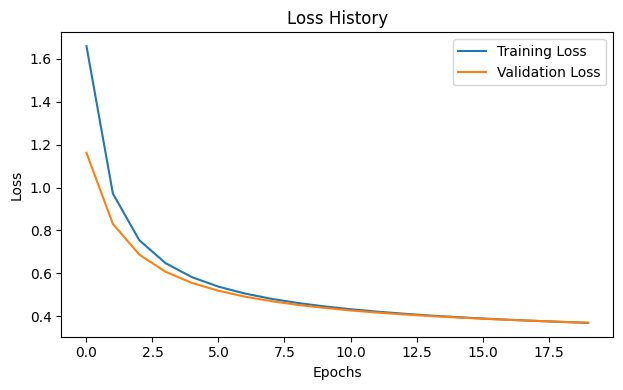


Evaluating model with linear activation...
Accuracy: 0.8948
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1343
           1       0.93      0.96      0.94      1600
           2       0.89      0.86      0.87      1380
           3       0.87      0.88      0.87      1433
           4       0.89      0.92      0.90      1295
           5       0.86      0.83      0.84      1273
           6       0.92      0.93      0.93      1396
           7       0.91      0.91      0.91      1503
           8       0.85      0.82      0.84      1357
           9       0.87      0.88      0.87      1420

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



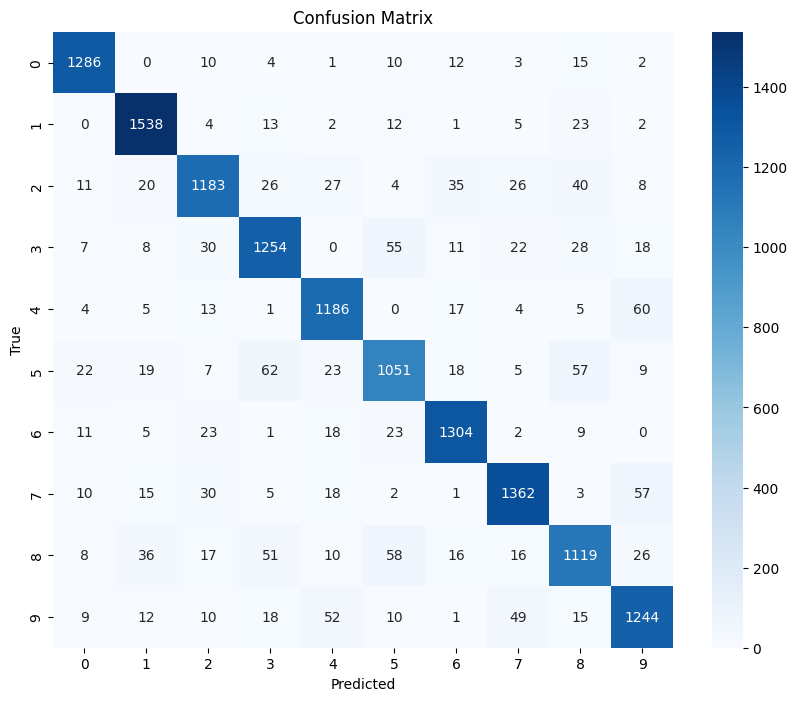

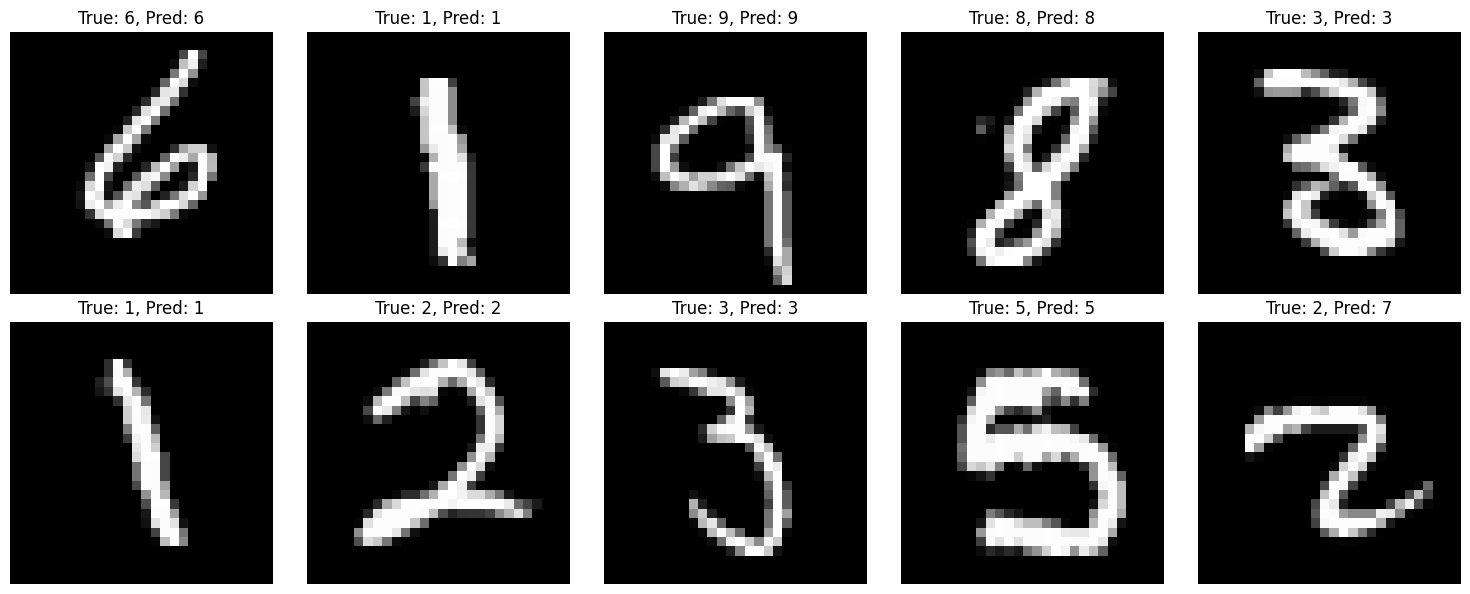


Weight distributions:


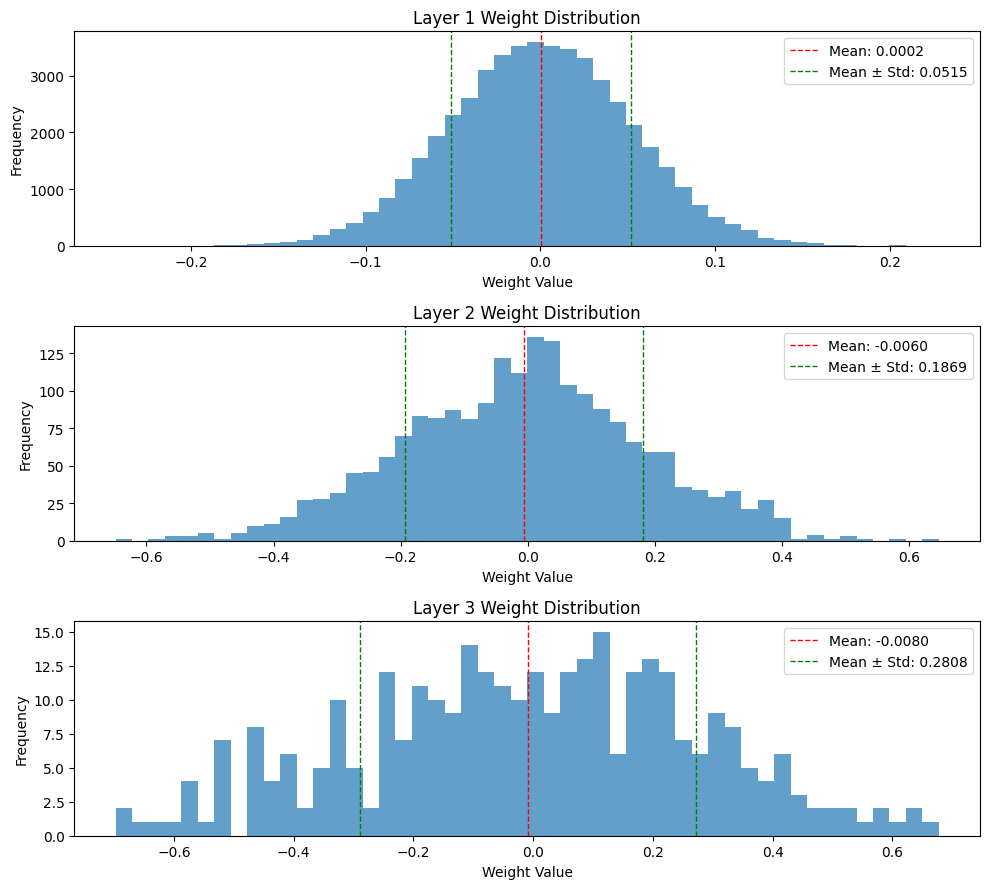


Gradient distributions:


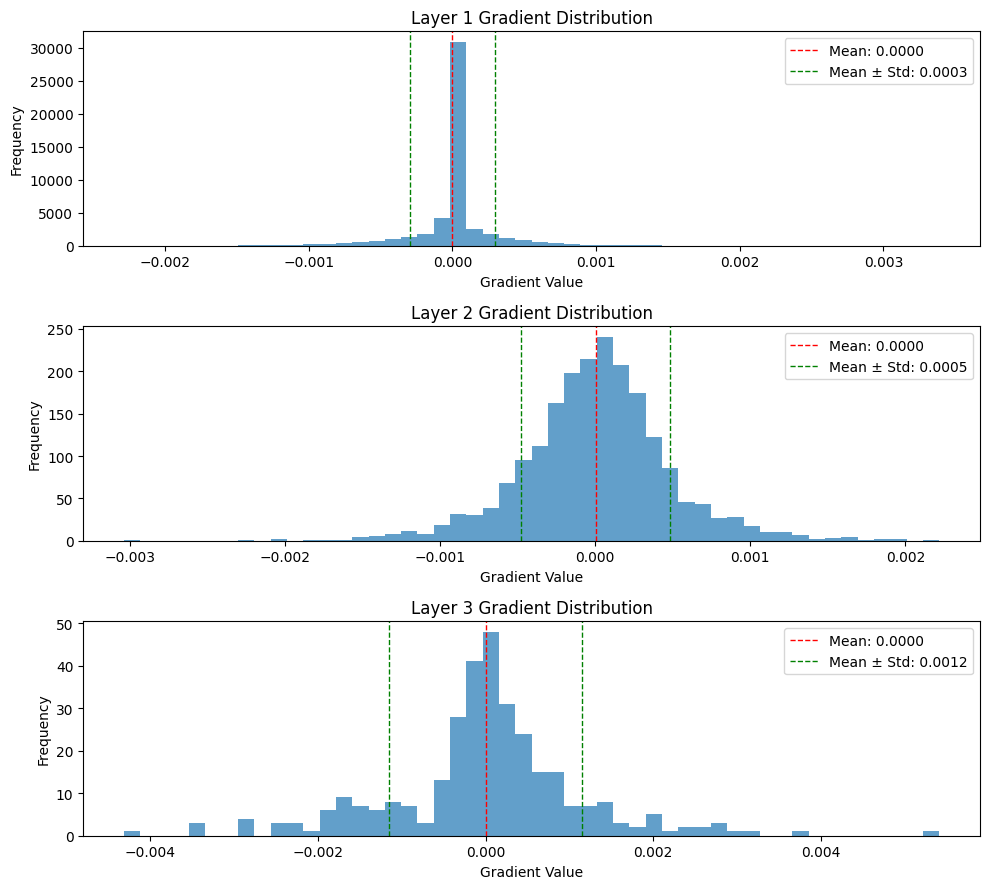


Training model with activation: relu
Epoch 1/20 [5.0%] - train_loss: 2.1180 - val_loss: 1.9161
Epoch 2/20 [10.0%] - train_loss: 1.7458 - val_loss: 1.5832
Epoch 3/20 [15.0%] - train_loss: 1.4312 - val_loss: 1.2799
Epoch 4/20 [20.0%] - train_loss: 1.1564 - val_loss: 1.0378
Epoch 5/20 [25.0%] - train_loss: 0.9552 - val_loss: 0.8712
Epoch 6/20 [30.0%] - train_loss: 0.8179 - val_loss: 0.7580
Epoch 7/20 [35.0%] - train_loss: 0.7225 - val_loss: 0.6783
Epoch 8/20 [40.0%] - train_loss: 0.6538 - val_loss: 0.6197
Epoch 9/20 [45.0%] - train_loss: 0.6024 - val_loss: 0.5753
Epoch 10/20 [50.0%] - train_loss: 0.5626 - val_loss: 0.5404
Epoch 11/20 [55.0%] - train_loss: 0.5310 - val_loss: 0.5124
Epoch 12/20 [60.0%] - train_loss: 0.5051 - val_loss: 0.4893
Epoch 13/20 [65.0%] - train_loss: 0.4836 - val_loss: 0.4696
Epoch 14/20 [70.0%] - train_loss: 0.4652 - val_loss: 0.4530
Epoch 15/20 [75.0%] - train_loss: 0.4494 - val_loss: 0.4386
Epoch 16/20 [80.0%] - train_loss: 0.4357 - val_loss: 0.4259
Epoch 17/20 

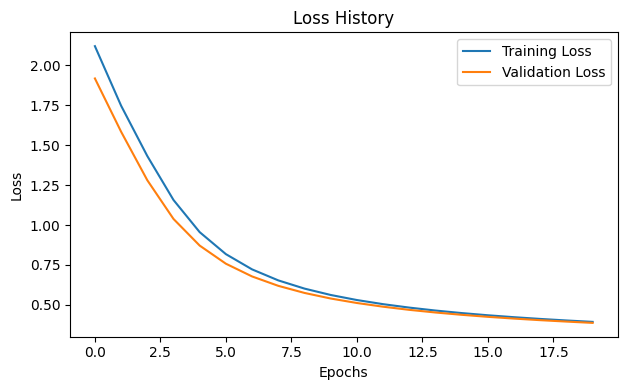


Evaluating model with relu activation...
Accuracy: 0.8918
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1343
           1       0.92      0.97      0.95      1600
           2       0.89      0.85      0.87      1380
           3       0.86      0.86      0.86      1433
           4       0.89      0.90      0.89      1295
           5       0.86      0.80      0.83      1273
           6       0.89      0.93      0.91      1396
           7       0.91      0.92      0.91      1503
           8       0.86      0.82      0.84      1357
           9       0.87      0.87      0.87      1420

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



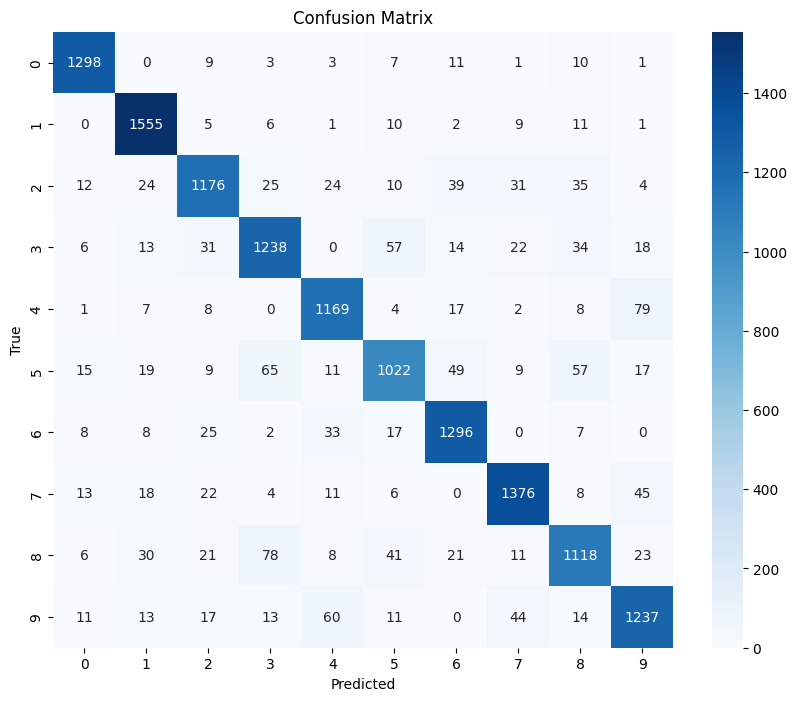

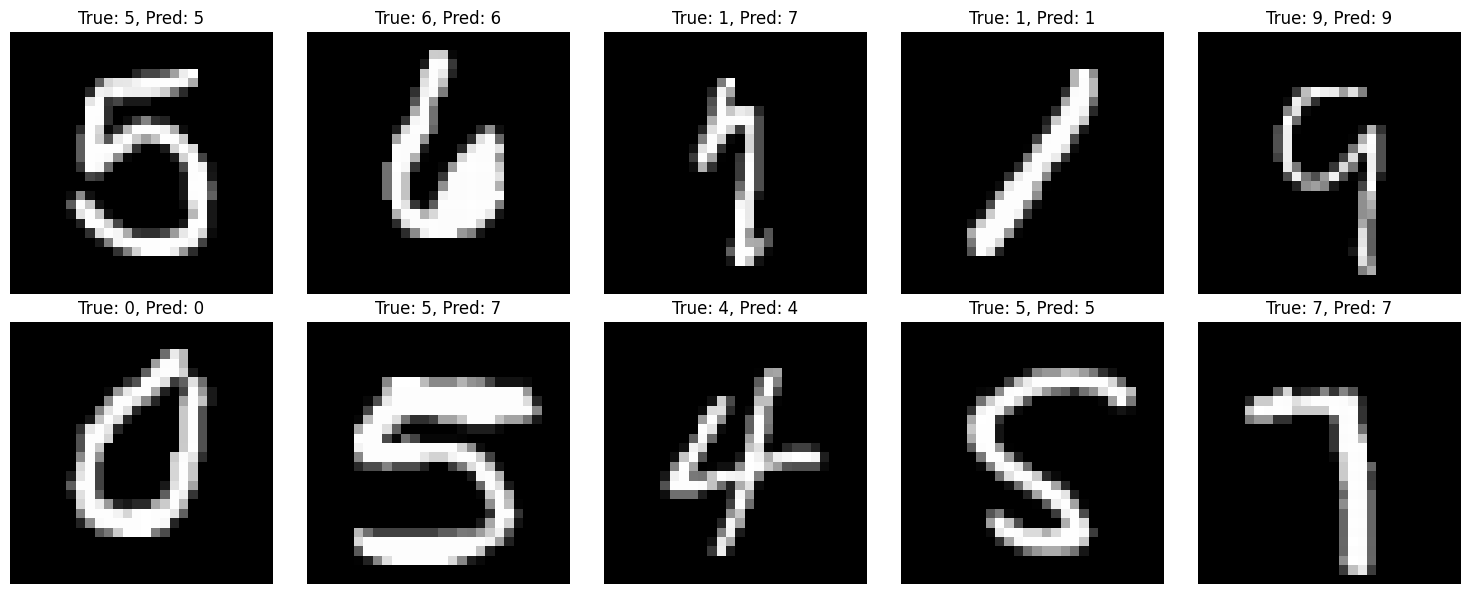


Weight distributions:


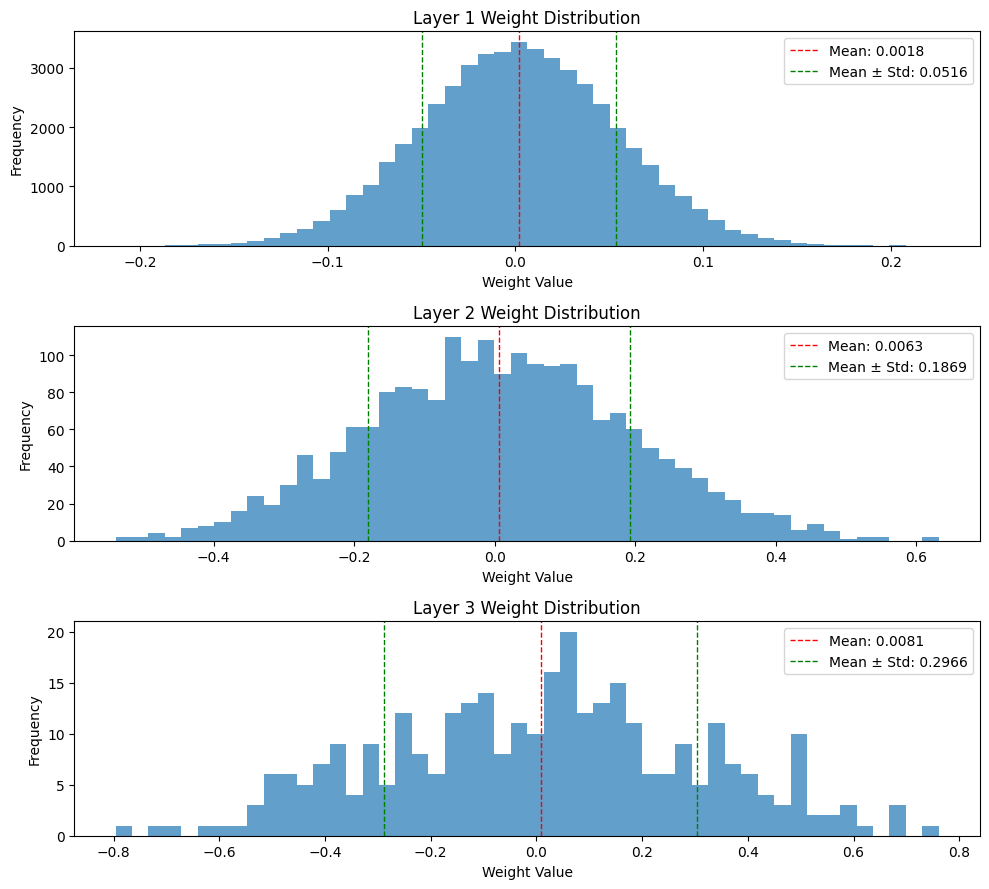


Gradient distributions:


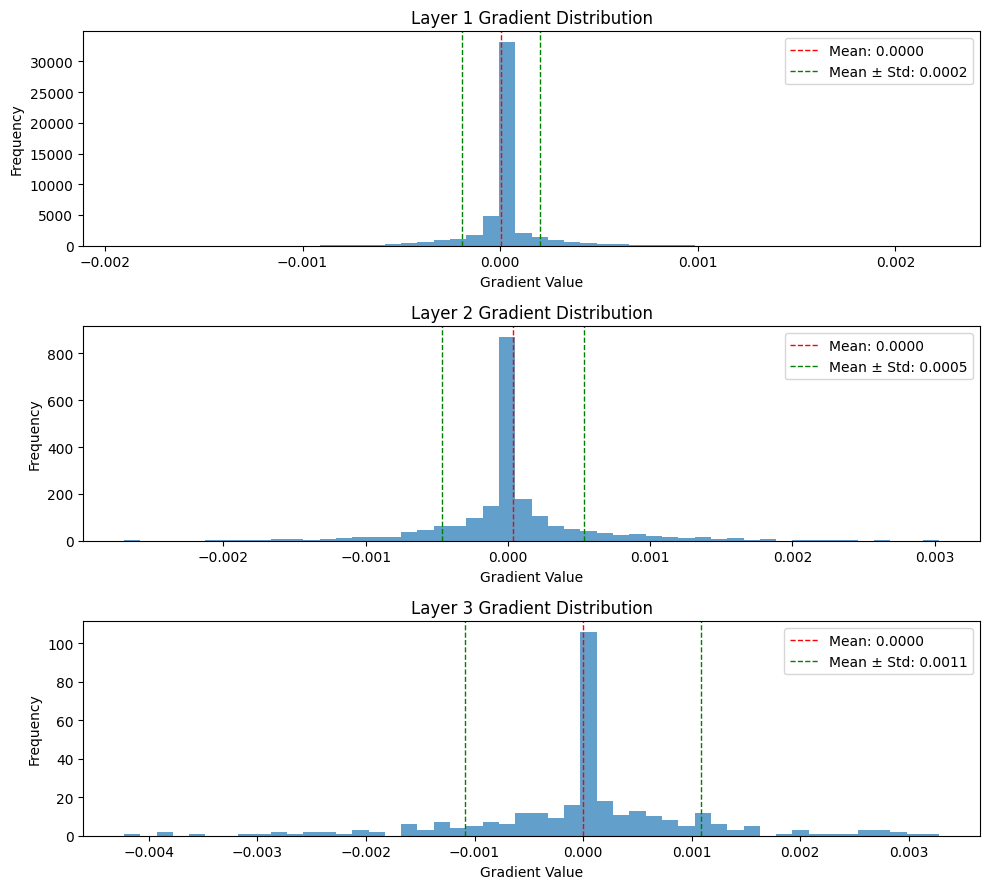


Training model with activation: sigmoid
Epoch 1/20 [5.0%] - train_loss: 2.4622 - val_loss: 2.3736
Epoch 2/20 [10.0%] - train_loss: 2.3401 - val_loss: 2.3151
Epoch 3/20 [15.0%] - train_loss: 2.3033 - val_loss: 2.2931
Epoch 4/20 [20.0%] - train_loss: 2.2872 - val_loss: 2.2815
Epoch 5/20 [25.0%] - train_loss: 2.2775 - val_loss: 2.2733
Epoch 6/20 [30.0%] - train_loss: 2.2699 - val_loss: 2.2661
Epoch 7/20 [35.0%] - train_loss: 2.2630 - val_loss: 2.2593
Epoch 8/20 [40.0%] - train_loss: 2.2563 - val_loss: 2.2526
Epoch 9/20 [45.0%] - train_loss: 2.2495 - val_loss: 2.2457
Epoch 10/20 [50.0%] - train_loss: 2.2425 - val_loss: 2.2387
Epoch 11/20 [55.0%] - train_loss: 2.2355 - val_loss: 2.2315
Epoch 12/20 [60.0%] - train_loss: 2.2282 - val_loss: 2.2242
Epoch 13/20 [65.0%] - train_loss: 2.2208 - val_loss: 2.2166
Epoch 14/20 [70.0%] - train_loss: 2.2132 - val_loss: 2.2088
Epoch 15/20 [75.0%] - train_loss: 2.2053 - val_loss: 2.2008
Epoch 16/20 [80.0%] - train_loss: 2.1971 - val_loss: 2.1925
Epoch 17/

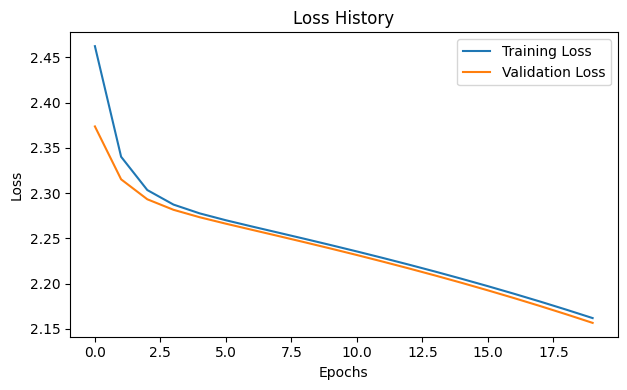


Evaluating model with sigmoid activation...
Accuracy: 0.5521
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1343
           1       0.35      0.99      0.52      1600
           2       0.79      0.44      0.57      1380
           3       0.56      0.64      0.60      1433
           4       0.77      0.46      0.58      1295
           5       1.00      0.00      0.00      1273
           6       0.82      0.75      0.78      1396
           7       0.44      0.92      0.59      1503
           8       0.80      0.35      0.49      1357
           9       0.55      0.05      0.10      1420

    accuracy                           0.55     14000
   macro avg       0.70      0.54      0.51     14000
weighted avg       0.69      0.55      0.51     14000



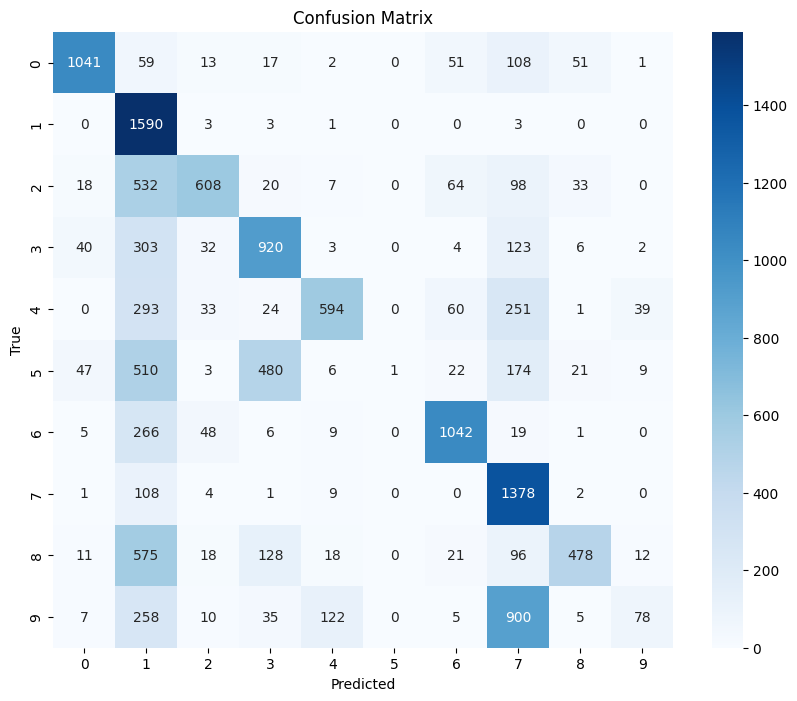

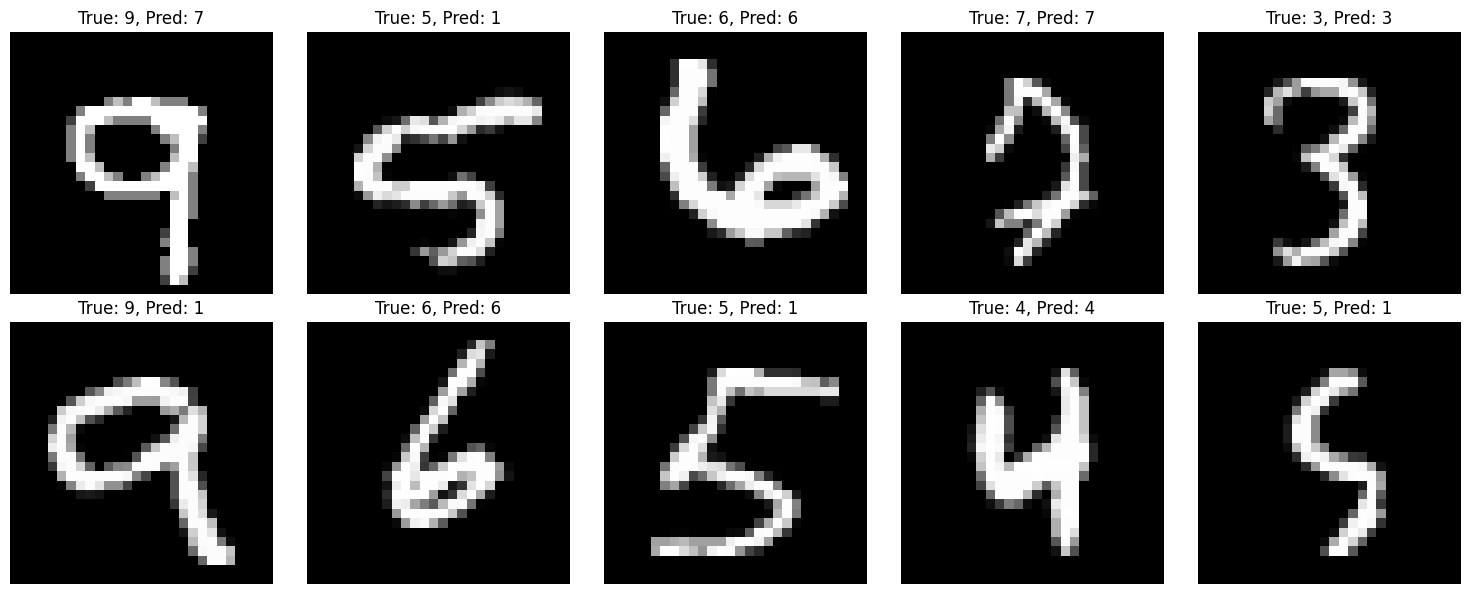


Weight distributions:


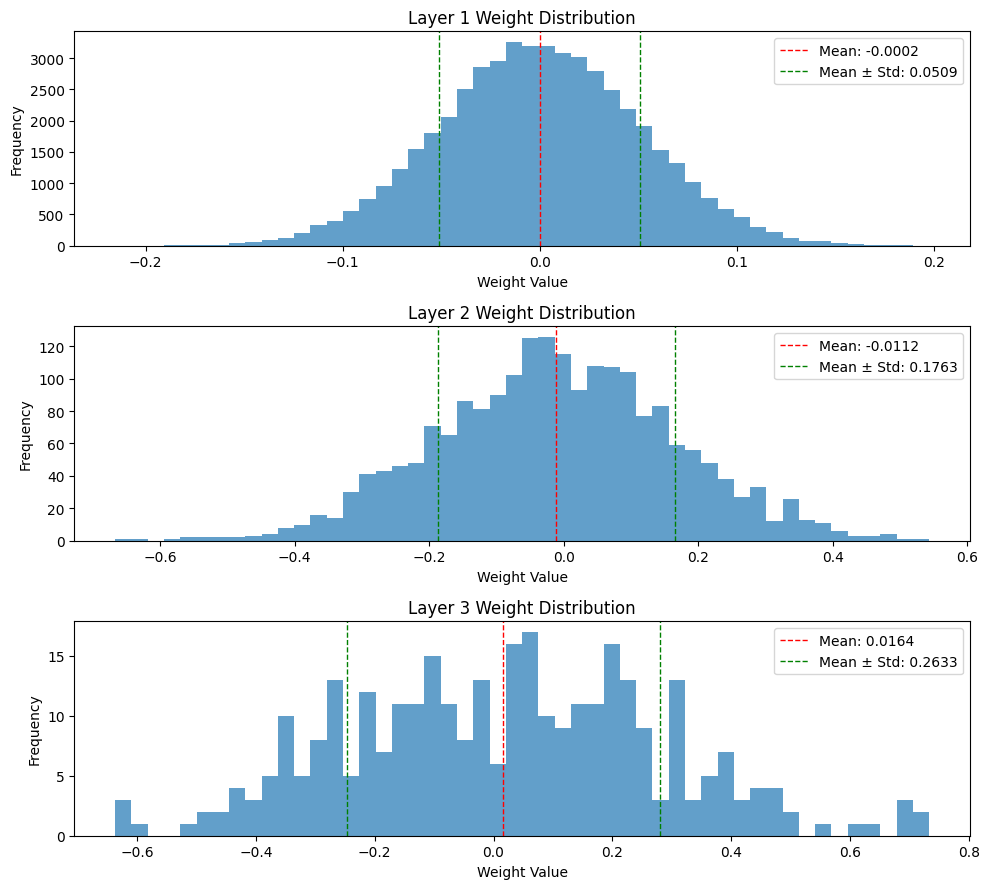


Gradient distributions:


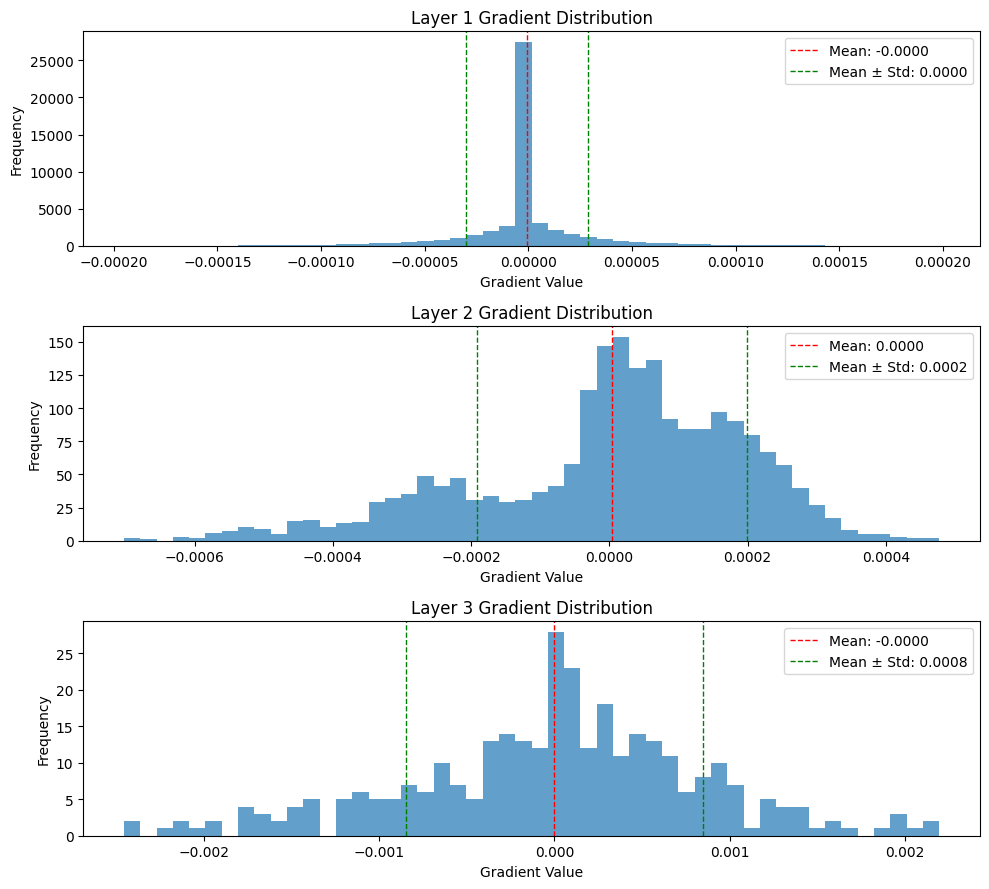


Training model with activation: tanh
Epoch 1/20 [5.0%] - train_loss: 1.9759 - val_loss: 1.6193
Epoch 2/20 [10.0%] - train_loss: 1.4217 - val_loss: 1.2565
Epoch 3/20 [15.0%] - train_loss: 1.1522 - val_loss: 1.0555
Epoch 4/20 [20.0%] - train_loss: 0.9904 - val_loss: 0.9257
Epoch 5/20 [25.0%] - train_loss: 0.8807 - val_loss: 0.8339
Epoch 6/20 [30.0%] - train_loss: 0.8009 - val_loss: 0.7655
Epoch 7/20 [35.0%] - train_loss: 0.7401 - val_loss: 0.7123
Epoch 8/20 [40.0%] - train_loss: 0.6919 - val_loss: 0.6696
Epoch 9/20 [45.0%] - train_loss: 0.6528 - val_loss: 0.6346
Epoch 10/20 [50.0%] - train_loss: 0.6203 - val_loss: 0.6052
Epoch 11/20 [55.0%] - train_loss: 0.5928 - val_loss: 0.5803
Epoch 12/20 [60.0%] - train_loss: 0.5693 - val_loss: 0.5588
Epoch 13/20 [65.0%] - train_loss: 0.5489 - val_loss: 0.5399
Epoch 14/20 [70.0%] - train_loss: 0.5310 - val_loss: 0.5234
Epoch 15/20 [75.0%] - train_loss: 0.5151 - val_loss: 0.5087
Epoch 16/20 [80.0%] - train_loss: 0.5009 - val_loss: 0.4956
Epoch 17/20 

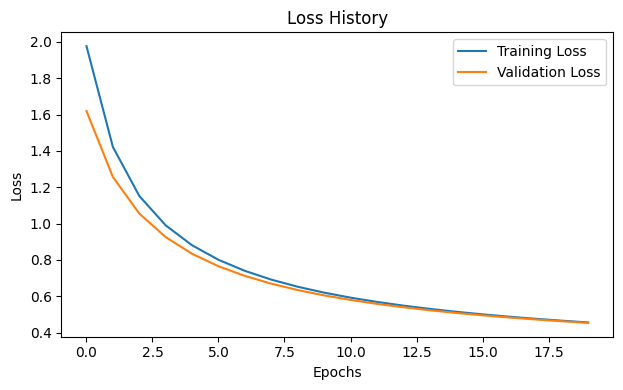


Evaluating model with tanh activation...
Accuracy: 0.8849
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1343
           1       0.91      0.96      0.94      1600
           2       0.88      0.83      0.86      1380
           3       0.85      0.87      0.86      1433
           4       0.88      0.89      0.89      1295
           5       0.85      0.81      0.83      1273
           6       0.91      0.93      0.92      1396
           7       0.90      0.91      0.91      1503
           8       0.85      0.81      0.83      1357
           9       0.86      0.87      0.86      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



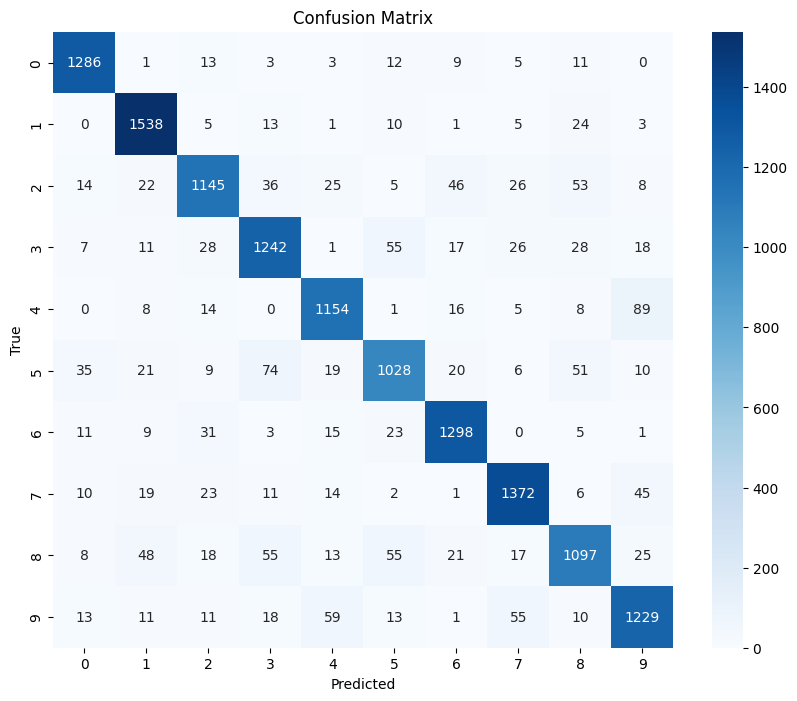

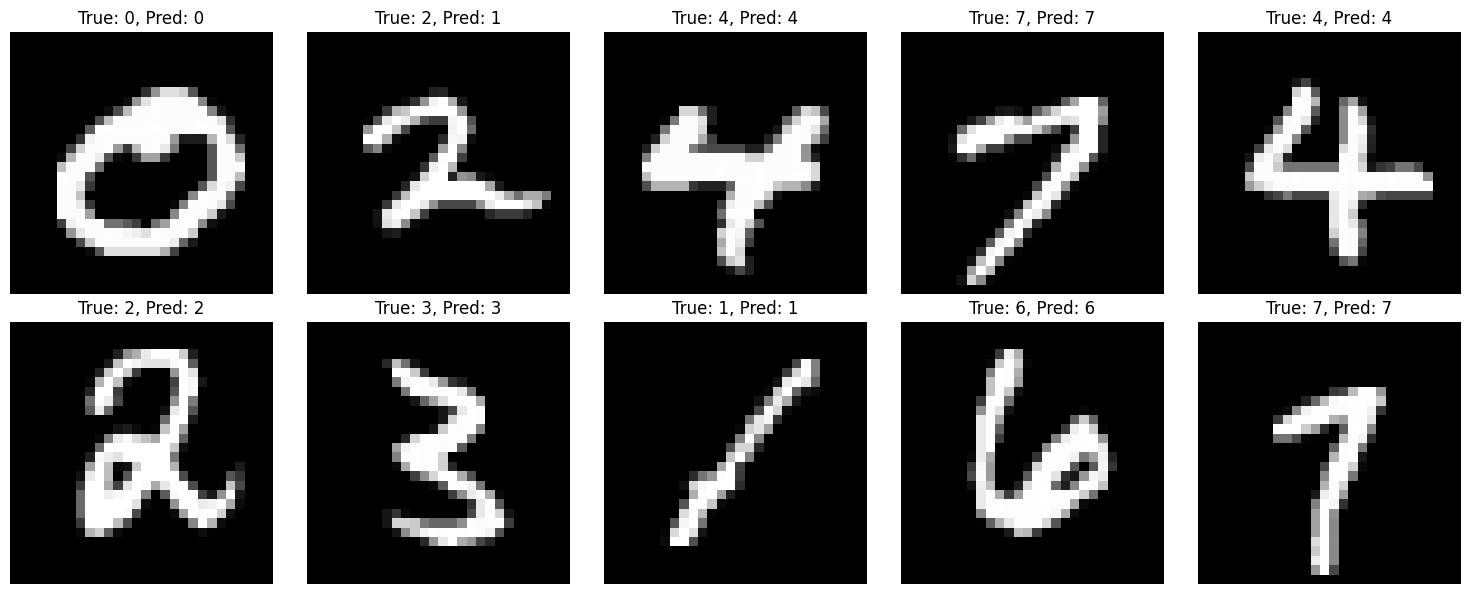


Weight distributions:


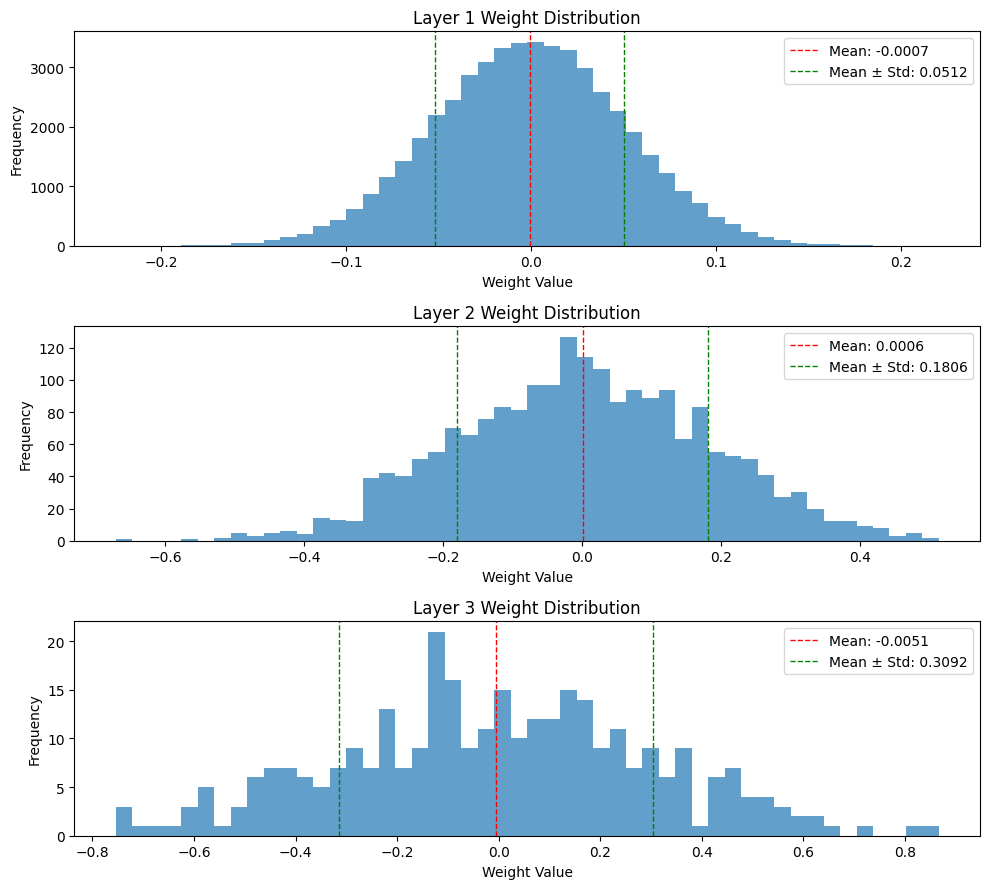


Gradient distributions:


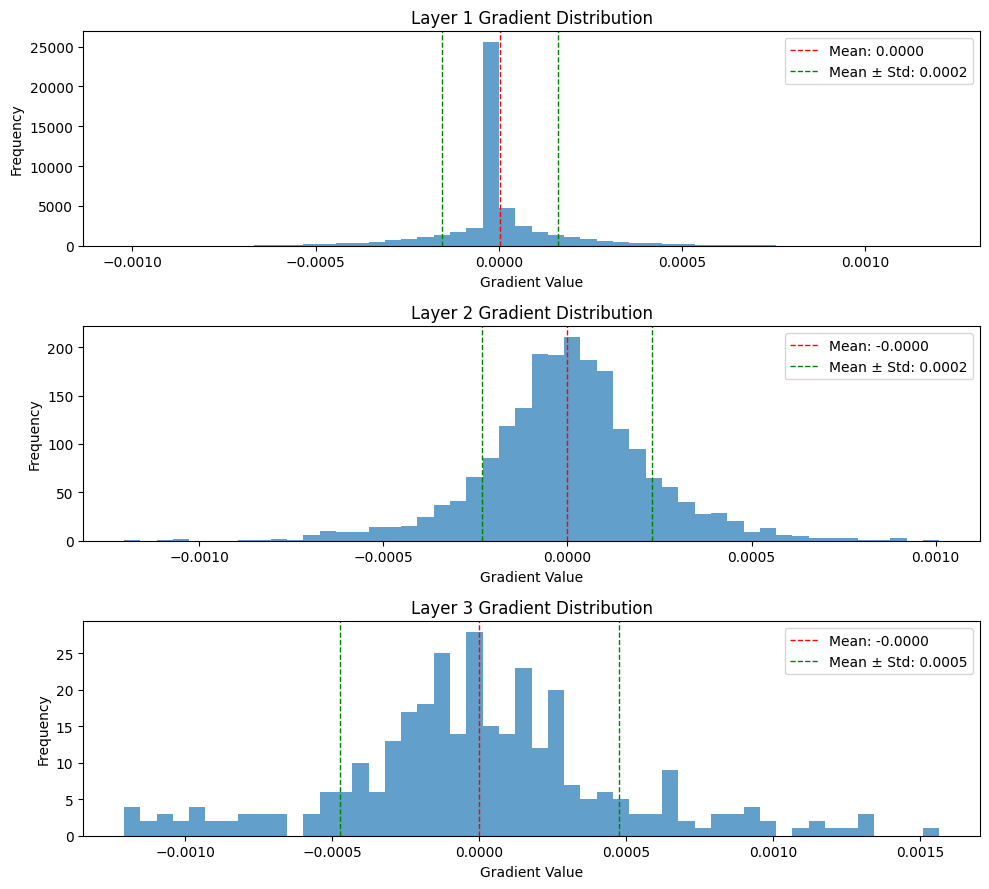


Activation Function Comparison Results:
  activation  accuracy  final_train_loss  final_val_loss  training_time
0     linear  0.894786          0.369739        0.370755      31.429600
1       relu  0.891786          0.394382        0.388035      31.099354
2    sigmoid  0.552143          2.161883        2.156583      34.238079
3       tanh  0.884929          0.456399        0.453952      34.596420


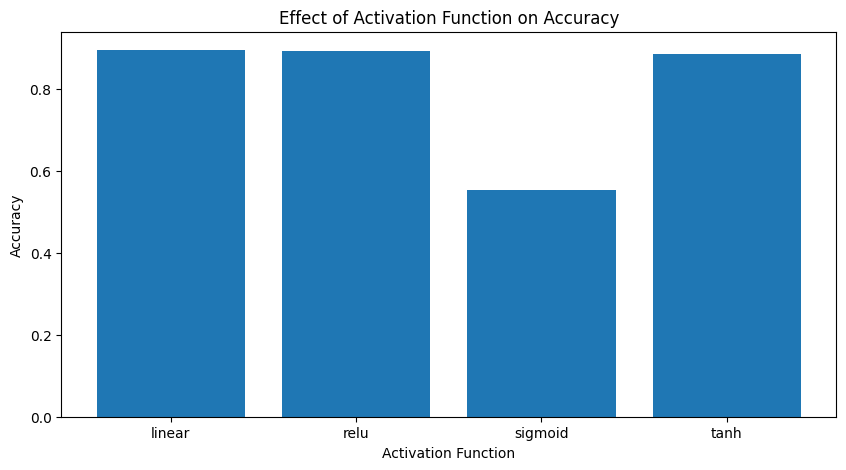

In [13]:
activation_results = []

for activation in activation_functions:
    print(f"\nTraining model with activation: {activation}")
    
    # Create activations list (softmax for output layer)
    activations = [activation] * (len(base_architecture['layers']) - 1) + ['softmax']
    
    # Initialize model
    model = FFNN_model.FeedforwardNeuralNetwork(
        input_size=X_train.shape[1],
        layer_sizes=base_architecture['layers'],
        activations=activations,
        loss=base_architecture['loss']
    )
    
    # Train the model
    start_time = time.time()
    history = model.train(
        X_train=X_train,
        y_train=y_train_onehot,
        X_val=X_test,
        y_val=y_test_onehot,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate'],
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Plot training history
    plot_history(history)
    
    # Evaluate model
    print(f"\nEvaluating model with {activation} activation...")
    accuracy, _ = evaluate_model(model, X_test, y_test_onehot, y_test)
    
    # Plot weight and gradient distributions
    print("\nWeight distributions:")
    model.plot_weight_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    print("\nGradient distributions:")
    model.plot_gradient_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    # Store results
    activation_results.append({
        'activation': activation,
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })

# Display activation results
print("\nActivation Function Comparison Results:")
activation_df = pd.DataFrame(activation_results)
print(activation_df[['activation', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])

# Plot comparative results
plt.figure(figsize=(10, 5))
plt.bar([r['activation'] for r in activation_results], [r['accuracy'] for r in activation_results])
plt.xlabel('Activation Function')
plt.ylabel('Accuracy')
plt.title('Effect of Activation Function on Accuracy')
plt.show()

## Experiment 3 : Effect of learning rate

## Experiment 4 : Effect of Weight Initialization

## Experiment 5 : Comparison with sklearn MLP

## Bonus Experiment 1: Effect of Regularization (L1 and L2)

## Bonus Experiment 2: Additional Activation Functions